# LSTM weeek

Torch LSTM tutorial: https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import re
import json
import ast
torch.manual_seed(1)

# Подготовим данные для обучения NER

In [23]:
df = pd.read_csv('datasets/for_train.csv')
df.head()

,text,new_text,task_type,person,time
0,Создай задачу : Подготовить отчет к 15 : 00 за...,создавать задача : подготовить отчет к 15 : 00...,['создавать задача : подготовить отчет к 15 : ...,['создавать задача : подготовить отчет к 15 : ...,['создавать задача : подготовить отчет к 15 : ...
1,Создай задание : Отправить приглашения на собр...,создавать задание : отправлять приглашение на ...,['создавать задание : отправлять приглашение н...,['создавать задание : отправлять приглашение н...,['создавать задание : отправлять приглашение н...
2,Создай задачу : Разработать презентацию к 18 :...,создавать задача : разрабатывать презентация к...,['создавать задача : разрабатывать презентация...,['создавать задача : разрабатывать презентация...,['создавать задача : разрабатывать презентация...
3,Назначь обязанность : Провести собрание с кома...,назначать обязанность : проводить собрание с к...,['назначать обязанность : проводить собрание с...,['назначать обязанность : проводить собрание с...,['назначать обязанность : проводить собрание с...
4,Поставь задачу : Подготовить план мероприятий ...,поставлять задача : подготовить план мероприят...,['поставлять задача : подготовить план меропри...,['поставлять задача : подготовить план меропри...,['поставлять задача : подготовить план меропри...


In [32]:
def get_entities(row):
  entities = list()
  if isinstance(row, str):
    m = re.search("{'entities.*}", row)
    ent_dict = ast.literal_eval(m.group(0))
    for x in ent_dict['entities']:
      entities.extend(row[x[0]+2:x[1]+2].split())
  return entities

data = list()
for i, row in df.iterrows():
  try:
    sent = row['new_text'].split()
    full_sent = row['text'].split()
    tokens = ['O'] * len(sent)
    persons = get_entities(row['person'])
    for person in persons:
      tokens[sent.index(person)] = 'PERSON'
    times = get_entities(row['time'])
    for time in times:
      tokens[sent.index(time)] = 'TIME'
    task_types = get_entities(row['task_type'])
    for task_type in task_types:
      tokens[sent.index(task_type)] = 'TASK'
    data.append((full_sent[:len(tokens)], tokens))
  except:
    print(type(row['person']))
    print(row['person'])
    raise

In [25]:
print(data[0])
print(data[20])
print(data[100])

(['Создай', 'задачу', ':', 'Подготовить', 'отчет', 'к', '15', ':', '00', 'завтра', 'на', 'Анну'], ['TASK', 'TASK', 'O', 'O', 'O', 'O', 'TIME', 'O', 'TIME', 'TIME', 'O', 'PERSON'])
(['Создай', 'задачу', ':', 'Подготовить', 'аналитический', 'отчет', 'к', '9', ':', '00', 'утра', 'на', 'Катю'], ['TASK', 'TASK', 'O', 'O', 'O', 'O', 'O', 'TIME', 'O', 'TIME', 'TIME', 'O', 'O'])
(['Создай', 'задание', ':', 'Обновить', 'документацию', 'к', '12', ':', '00', 'утра', 'на', 'Наталью'], ['TASK', 'TASK', 'O', 'O', 'O', 'O', 'TIME', 'O', 'TIME', 'TIME', 'O', 'PERSON'])


# LSTM for NER

In [33]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

split_idx = int(len(data)*0.8) #80% - трейн, 20% - тест
training_data = data[:split_idx]
test_data = data[split_idx:]
word_to_ix = {}

In [34]:
for sent, tags in data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

print(word_to_ix)

tag_to_ix = {"O": 0, "TASK": 1, "PERSON": 2, "TIME": 3}

print(tag_to_ix)

EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'Создай': 0, 'задачу': 1, ':': 2, 'Подготовить': 3, 'отчет': 4, 'к': 5, '15': 6, '00': 7, 'завтра': 8, 'на': 9, 'Анну': 10, 'задание': 11, 'Отправить': 12, 'приглашения': 13, 'собрание': 14, '10': 15, 'утра': 16, 'Ивана': 17, 'Разработать': 18, 'презентацию': 19, '18': 20, 'сегодня': 21, 'Сергея': 22, 'Назначь': 23, 'обязанность': 24, 'Провести': 25, 'с': 26, 'командой': 27, 'в': 28, '14': 29, '30': 30, 'Ольгу': 31, 'Поставь': 32, 'план': 33, 'мероприятий': 34, '12': 35, 'следующий': 36, 'день': 37, 'Наталью': 38, 'Задай': 39, 'письмо': 40, 'уточнениями': 41, '16': 42, 'Василия': 43, 'Проверить': 44, 'документацию': 45, '9': 46, 'Дениса': 47, 'Дай': 48, 'поручение': 49, 'бюджет': 50, 'проекта': 51, '17': 52, 'Екатерину': 53, 'тренинг': 54, 'сотрудников': 55, '11': 56, 'Артура': 57, 'резюме': 58, 'Марину': 59, 'до': 60, 'конца': 61, 'дня': 62, 'стратегию': 63, 'маркетинга': 64, 'Согласовать': 65, 'график': 66, 'работы': 67, 'о': 68, 'выполнении': 69, 'обучение': 70, 'новых': 71, 'корпо

In [35]:
# Model:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [36]:
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    print(inputs)
    print(word_to_ix)

tensor([ 0,  1,  2,  3,  4,  5,  6,  2,  7,  8,  9, 10])
{'Создай': 0, 'задачу': 1, ':': 2, 'Подготовить': 3, 'отчет': 4, 'к': 5, '15': 6, '00': 7, 'завтра': 8, 'на': 9, 'Анну': 10, 'задание': 11, 'Отправить': 12, 'приглашения': 13, 'собрание': 14, '10': 15, 'утра': 16, 'Ивана': 17, 'Разработать': 18, 'презентацию': 19, '18': 20, 'сегодня': 21, 'Сергея': 22, 'Назначь': 23, 'обязанность': 24, 'Провести': 25, 'с': 26, 'командой': 27, 'в': 28, '14': 29, '30': 30, 'Ольгу': 31, 'Поставь': 32, 'план': 33, 'мероприятий': 34, '12': 35, 'следующий': 36, 'день': 37, 'Наталью': 38, 'Задай': 39, 'письмо': 40, 'уточнениями': 41, '16': 42, 'Василия': 43, 'Проверить': 44, 'документацию': 45, '9': 46, 'Дениса': 47, 'Дай': 48, 'поручение': 49, 'бюджет': 50, 'проекта': 51, '17': 52, 'Екатерину': 53, 'тренинг': 54, 'сотрудников': 55, '11': 56, 'Артура': 57, 'резюме': 58, 'Марину': 59, 'до': 60, 'конца': 61, 'дня': 62, 'стратегию': 63, 'маркетинга': 64, 'Согласовать': 65, 'график': 66, 'работы': 67, 'о': 

In [37]:
targets = prepare_sequence(tags, tag_to_ix)
print(targets)

tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3])


In [38]:
# Train the model
from sklearn.metrics import accuracy_score

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

train_losses = list()
test_losses = list()
acc_scores = list()

for epoch in range(1, 101, 1):
    print(epoch)
    loss_list=list()
    for sentence, tags in training_data:
        model.zero_grad()
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)
        tag_scores = model(sentence_in)
        loss = loss_function(tag_scores, targets)
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for sentence, tags in test_data:
            sentence_in = prepare_sequence(sentence, word_to_ix)
            targets = prepare_sequence(tags, tag_to_ix)
            preds = model(sentence_in)
            loss = loss_function(preds, targets)
            losses.append(loss.item())
            Y_shuffled.append(targets)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)
        test_loss = torch.tensor(losses).mean()
        acc_score = accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())
        train_loss = np.mean(loss_list)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        acc_scores.append(acc_score)
        print("Train Loss : {:.3f}".format(train_loss))
        print("Valid Loss : {:.3f}".format(test_loss))
        print("Valid Acc  : {:.3f}".format(acc_score))


1
Train Loss : 0.738
Valid Loss : 0.611
Valid Acc  : 0.821
2
Train Loss : 0.400
Valid Loss : 0.525
Valid Acc  : 0.826
3
Train Loss : 0.321
Valid Loss : 0.507
Valid Acc  : 0.830
4
Train Loss : 0.277
Valid Loss : 0.471
Valid Acc  : 0.840
5
Train Loss : 0.231
Valid Loss : 0.444
Valid Acc  : 0.846
6
Train Loss : 0.189
Valid Loss : 0.435
Valid Acc  : 0.846
7
Train Loss : 0.161
Valid Loss : 0.423
Valid Acc  : 0.849
8
Train Loss : 0.154
Valid Loss : 0.842
Valid Acc  : 0.821
9
Train Loss : 0.149
Valid Loss : 0.428
Valid Acc  : 0.845
10
Train Loss : 0.117
Valid Loss : 0.443
Valid Acc  : 0.857
11
Train Loss : 0.110
Valid Loss : 0.442
Valid Acc  : 0.857
12
Train Loss : 0.142
Valid Loss : 0.789
Valid Acc  : 0.819
13
Train Loss : 0.124
Valid Loss : 0.427
Valid Acc  : 0.865
14
Train Loss : 0.099
Valid Loss : 0.439
Valid Acc  : 0.865
15
Train Loss : 0.091
Valid Loss : 0.439
Valid Acc  : 0.867
16
Train Loss : 0.085
Valid Loss : 0.443
Valid Acc  : 0.863
17
Train Loss : 0.078
Valid Loss : 0.449
Valid Ac

In [39]:
for test_case in test_data:
  test_case = test_case[0]
  print(' '.join(test_case))

  with torch.no_grad():
      inputs = prepare_sequence(test_case, word_to_ix)
      tag_scores = model(inputs)
      results = [(tag_scores == max(i)).nonzero(as_tuple=False)[0][1].item() for i in tag_scores]
      ix_to_tag = {v:k for k,v in tag_to_ix.items()}
      translations = [ix_to_tag[i] for i in results]

  print("TASK: {}".format(' '.join([test_case[i] for i in range(len(test_case)) if translations[i]=="TASK"])))
  print("PERSON: {}".format(' '.join([test_case[i] for i in range(len(test_case)) if translations[i]=="PERSON"])))
  print("TIME: {}".format(' '.join([test_case[i] for i in range(len(test_case)) if translations[i]=="TIME"])))
  print("DESC:{}".format(' '.join(test_case)))
  print('')

Создай задачу : Сергей должен предоставить 3 варианта дизайна упаковки до конца этой недели
TASK: Создай задачу
PERSON: Сергей
TIME: до конца этой недели
DESC:Создай задачу : Сергей должен предоставить 3 варианта дизайна упаковки до конца этой недели

Создай задачу : Петр требуется верстка лендинга в течение 2 дней после утверждения макета
TASK: Создай задачу
PERSON: после
TIME: 2 дней
DESC:Создай задачу : Петр требуется верстка лендинга в течение 2 дней после утверждения макета

Создай задачу : Олег нужны эскизы интерьера офиса к понедельнику
TASK: Создай задачу
PERSON: Олег
TIME: 
DESC:Создай задачу : Олег нужны эскизы интерьера офиса к понедельнику

Создай задачу : Анна пожалуйста разработай несколько вариантов баннера ко Дню рождения компании ко 2 апреля
TASK: Создай задачу
PERSON: Анна
TIME: 
DESC:Создай задачу : Анна пожалуйста разработай несколько вариантов баннера ко Дню рождения компании ко 2 апреля

Создай задачу : Максим требуется дизайн новогодних открыток к 15 декабря
TASK

In [40]:
for test_case in ['Создай задачу : Олеся должна предоставить эскиз нового карнавального костюма завтра к 11 : 00'.split()]:
  print(' '.join(test_case))

  with torch.no_grad():
      inputs = prepare_sequence(test_case, word_to_ix)
      tag_scores = model(inputs)
      results = [(tag_scores == max(i)).nonzero(as_tuple=False)[0][1].item() for i in tag_scores]
      ix_to_tag = {v:k for k,v in tag_to_ix.items()}
      translations = [ix_to_tag[i] for i in results]

  print("TASK: {}".format(' '.join([test_case[i] for i in range(len(test_case)) if translations[i]=="TASK"])))
  print("PERSON: {}".format(' '.join([test_case[i] for i in range(len(test_case)) if translations[i]=="PERSON"])))
  print("TIME: {}".format(' '.join([test_case[i] for i in range(len(test_case)) if translations[i]=="TIME"])))
  print("DESC:{}".format(' '.join(test_case)))
  print('')

Создай задачу : Олеся должна предоставить эскиз нового карнавального костюма завтра к 11 : 00


KeyError: ignored

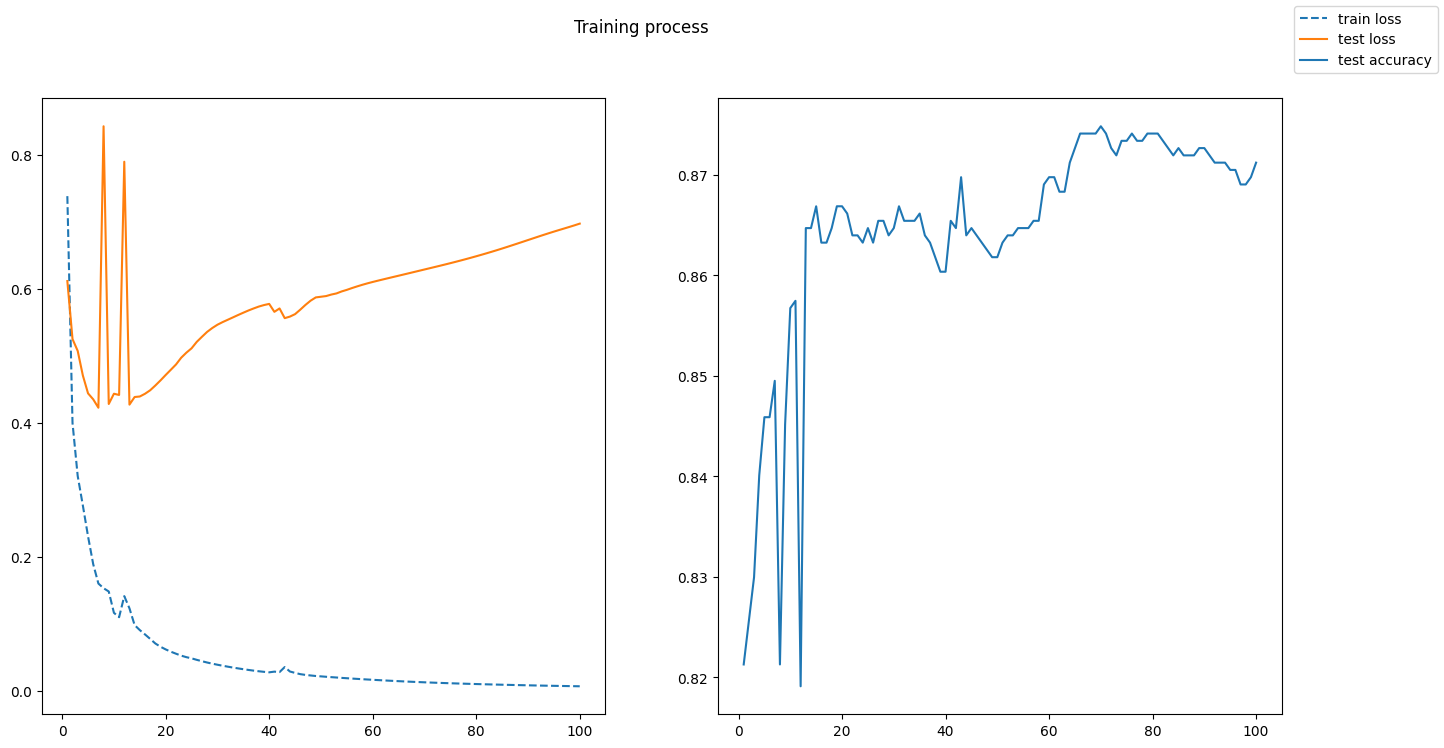

In [42]:
import matplotlib.pyplot as plt

t = range(1, 101, 1)

#train_losses, test_losses, acc_scores
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16, 8))
ax[0].plot(t, train_losses, label = "train loss", linestyle="--")
ax[0].plot(t, test_losses, label = "test loss")
ax[1].plot(t, acc_scores, label = "test accuracy")
fig.suptitle("Training process")
fig.legend()
plt.show()

In [48]:
def calc_estimations(target, translations):
  result = list()
  for i in range(len(target)):
    if target[i]==translations[i] and target[i]!= 'O':
      result.append('COR')
    elif target[i]!= 'O' and translations[i]=='O':
      result.append('MIS')
    elif target[i]== 'O' and translations[i]!='O':
      result.append('SPU')
    elif target[i]!= 'O' and translations[i]!='O' and target[i]!=translations[i]:
      result.append('INC')
    else:
      pass
  return result

total_result = list()
for test_case in test_data:
  test_case, target = test_case[0], test_case[1]

  with torch.no_grad():
      inputs = prepare_sequence(test_case, word_to_ix)
      tag_scores = model(inputs)
      results = [(tag_scores == max(i)).nonzero(as_tuple=False)[0][1].item() for i in tag_scores]
      ix_to_tag = {v:k for k,v in tag_to_ix.items()}
      translations = [ix_to_tag[i] for i in results]
      total_result.extend(calc_estimations(target, translations))


In [50]:
Precision = sum([x=='COR' for x in total_result])/sum([x in ['COR', 'INC', 'SPU'] for x in total_result])
Recall = sum([x=='COR' for x in total_result])/sum([x in ['COR', 'INC', 'MIS'] for x in total_result])
F1 = 2*Recall*Precision/(Recall+Precision)

print(f"Precision: {Precision}")
print(f"Recall: {Recall}")
print(f"F1-score: {F1}")

Precision: 0.8277634961439588
Recall: 0.7368421052631579
F1-score: 0.7796610169491525


In [51]:
torch.save(model, "LSTM_NER.pth")

In [52]:
# Сохраним словарь
with open('vocab.json', 'w') as f:
  f.write(json.dumps(word_to_ix))

# Сохраним типы разметки
with open('tag_to_ix.json', 'w') as f:
  f.write(json.dumps(tag_to_ix))
